<a href="https://colab.research.google.com/github/Gauthameshwar/RAQS_QuantumInspiredAlgos/blob/master/notebooks/GroundStateTensorTrains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPS + DMRG Ground-State Notebook (Julia/ITensor)
  
> **Goal**: Build intuition for Matrix Product States (MPS), implement and understand DMRG (ground state search) for a given MPO, then solve a **tilted Ising chain** end-to-end (Hamiltonian, DMRG, diagnostics, plots).  
> **Style**: Hands-on, research-grade. Clear derivations + minimal, readable code with standard Julia library implementations.

---

**Learning Objectives**

- Understand **MPS/TT** as low-entanglement factorizations; connect to **compression/latent-factor models** (e.g., SVD/PCA) in non-quantum data.
- Put an MPS into **left/right/mixed canonical** form; move the **orthogonality center (OC)** and know why this is essential for local variational updates (DMRG/TEBD).
- Build the **tilted Ising** Hamiltonian as an **MPO** and translate formulas → code.
- Run **two-site DMRG** robustly; know when/why to use one-site and how to add noise/subspace expansion.
- Read **diagnostics**: discarded weight, energy variance, bond-dimension profile; decide convergence.
- Measure **observables** (magnetizations, correlators) and **entanglement entropy**; make clean plots.

> **Prerequisites**: Fair introduction to tensor networks, data compression in MPS, basic Julia coding, tensor products in quantum physics, and introduction to quantum spins.

---


## 0. Setup & Notebook Skeleton

- Use Julia ≥ 1.11. Prefer a **project-based** workflow for reproducibility.
- Recommended packages: `ITensors`, `KrylovKit`, `Printf`, `Logging`, `Random`, `LinearAlgebra`.

> **ITensor vs “algorithms”**
>
> In Julia, **ITensors.jl** provides both tensor primitives **and** high-level routines like `dmrg`. We’ll still write thin wrappers so parameters and logging are clean and reproducible.



In [1]:
const USER = "Gauthameshwar"
const REPO = "RAQS_QuantumInspiredAlgos"
const BRANCH = "master"

# cd("/content")

# if !isdir(REPO)
#   run(`git clone --depth 1 -b 
# USER/$REPO.git`)
# end

# proj = joinpath("/content", REPO, "env")  # where Project.toml lives

import Pkg
localpath = "/Users/gauthameshwar/Documents/VSCode/RAQS_QuantumInspiredAlgos" # Use your local path if running this notebook on your local computer
proj = joinpath(localpath, "env")  # local path
isfile(joinpath(proj, "Project.toml")) || error("Project.toml not found: $proj")


Pkg.activate(proj)
Pkg.instantiate()   # uses Manifest.toml if present; pins exact versions

  Activating project at `~/Documents/VSCode/RAQS_QuantumInspiredAlgos/env`


> **Tip**
>
> For reproducibility, use the provided enfironment and set a seed: `Random.seed!(1234)` to get consistent results during the sweeps.


In [2]:
using Random, LinearAlgebra, ITensors, ITensorMPS # For constructing and using the MPS algos
using Plots, Printf, Logging, LaTeXStrings # For plotting, formatting the print statements, and logging

Random.seed!(1234) 

TaskLocalRNG()

## 1. MPS: Concept → Canonical Forms → Cost

### 1.1 Why MPS?
- **Exponential wall** — a generic state $|\psi\rangle$ on $N$ qubits needs $2^N$ amplitudes in its dense form.
- **Area-law intuition** — many **1D ground states** have short-range entanglement; a **Matrix Product State (MPS)** factors $|\psi\rangle$ into local tensors with bond dimension $\chi \ll 2^{N/2}$.
- **Schmidt/SVD picture** — cut at bond $(\ell\,|\,\ell+1)$ and write
$$
|\psi\rangle = \sum_{\alpha=1}^{\chi^*} \lambda_\alpha\, |\alpha_L\rangle \otimes |\alpha_R\rangle,
$$
keeping only the largest $\chi$ singular values $\{\lambda_\alpha\}$ to form a rank-$\chi$ approximation, thus compressing the information significantly.

> **Entanglement & truncation** — with $p_\alpha = \lambda_\alpha^2$, the bipartite entropy is
> $$
> S = -\sum_\alpha p_\alpha \log p_\alpha,
> $$
> and the **discarded weight** $\delta = \sum_{\alpha>\chi} \lambda_\alpha^2$ upper-bounds the 2-norm truncation error. This mirrors **truncated SVD/PCA** denoising.

---


### 1.2 MPS Definition

An **MPS** of length $N$ over local dimension $d$ is written as a contracted chain of **site tensors** $A^{[k]}$ with one physical leg $i_k\in\{1,\dots,d\}$ and two virtual (bond) legs $\alpha_{k-1},\alpha_k$:

$$
C_{i_1\cdots i_N}
\;=\;
\sum_{\alpha_1,\dots,\alpha_{N-1}}
A^{[1]}_{1\,i_1\,\alpha_1}\,
A^{[2]}_{\alpha_1\,i_2\,\alpha_2}\,
\cdots\,
A^{[N]}_{\alpha_{N-1}\,i_N\,1}.
$$
Open boundaries are encoded by $\chi_0=\chi_N=1$. Equivalently, grouping the $d$ physical slices $A^{[k]\,i_k}$ as $\chi_{k-1}\times\chi_k$ matrices gives the shorthand
$$
|\psi\rangle \;=\; \sum_{i_1,\ldots,i_N} \big(A^{[1]\,i_1} A^{[2]\,i_2}\cdots A^{[N]\,i_N}\big)\,|i_1\cdots i_N\rangle.
$$
The **bond dimensions** $(\chi_0,\ldots,\chi_N)$ control expressiveness; the key complexity knob is $\chi=\max_k \chi_k$.


In [3]:
N  = 6
χ0 = 10

# Build site indices (Qubit convention so X,Z have eigenvalues ±1)
s  = siteinds("Qubit", N)

# Small random MPS; ITensors.jl returns an MPS object
ψ = randomMPS(s, χ0)
normalize!(ψ)

@printf "Toy MPS: N=%d, initial χ0≈%d\n" N χ0
@printf "MPS Details:\n"
for b in eachindex(ψ)
    @printf "  Site %d: dims=%s\n" b size(ψ[b])
end

# println("ψ inds = ", inds(ψ))

Toy MPS: N=6, initial χ0≈10
MPS Details:
  Site 1: dims=(2, 10)
  Site 2: dims=(10, 2, 10)
  Site 3: dims=(10, 2, 8)
  Site 4: dims=(8, 2, 4)
  Site 5: dims=(4, 2, 2)
  Site 6: dims=(2, 2)


### 1.2 Canonical Forms of MPS

**Motivation.**  
The MPS representation of a tensor network state is not unique: it has *gauge freedom*. This freedom allows us to choose a **canonical form** that simplifies contractions, stabilizes variational updates, and gives a clean way to truncate. With tensors in canonical gauge:  
- **Easy contractions:** environments collapse to identities, reducing cost.  
- **Stable optimization:** local effective Hamiltonians are well conditioned, preventing numerical instabilities.  
- **Predictable truncation:** the SVD at the orthogonality center (OC) directly reveals the best rank-$\chi$ approximation.  

Without canonicalization, DMRG sweeps would be unstable and entanglement measures harder to extract.

---

**From Schmidt to canonical MPS.**  
For a cut $(1\ldots i)\,|\,(i+1\ldots N)$, the Schmidt decomposition gives a bipartition with orthonormal vectors on both sides:
$$
|\psi\rangle
= \sum_{\alpha=1}^{r_i}\lambda^{[i]}_\alpha\,
|\alpha^{[i]}_L\rangle\otimes|\alpha^{[i]}_R\rangle,
\qquad r_i\le \min(d^i,d^{N-i}).
$$

By adjusting the gauges of the local tensors $A^{[k]}$, the Schmidt vectors can be identified directly with contractions of those tensors. The diagonal matrix $\Lambda^{[i]}=\mathrm{diag}(\lambda^{[i]}_\alpha)$ then appears explicitly on the cut, which is the **canonical form** for the bond $i$.

---

**Gauge freedom (local equivalence).**  
Any invertible matrix $G_i$ can be inserted on a bond and absorbed into neighboring tensors:
$$
A^{[i]} \mapsto A^{[i]} G_i,\qquad
A^{[i+1]} \mapsto G_i^{-1} A^{[i+1]}.
$$
This local freedom allows us to perform QR/SVD factorizations site by site, enforcing orthonormality conditions.

---

**Left- and right-orthonormality.**  
Interpreting $A^{[i]}$ as a map from $(\alpha_{i-1}, i_i)$ into $\alpha_i$:
- **Left-orthonormal:**  
  $$
  \sum_{i_i}(A^{[i]\,i_i})^\dagger A^{[i]\,i_i} = I_{\chi_i}.
  $$
- **Right-orthonormal:**  
  $$
  \sum_{i_i}A^{[i]\,i_i}(A^{[i]\,i_i})^\dagger = I_{\chi_{i-1}}.
  $$

These conditions mean that the tensors act as **isometries**: they preserve orthogonality across the chain.

---

**Mixed canonical form & the orthogonality center (OC).**  
By sweeping QR/SVD factorizations along the chain we can place the MPS in a **mixed gauge**:  
- Sites $1,\ldots,i-1$ are left-orthonormal (denoted $\mathrm{iso}_L^{[k]}$).  
- Sites $i+1,\ldots,N$ are right-orthonormal (denoted $\mathrm{iso}_R^{[k]}$).  
- A center tensor $C^{[i]}$ holds the remaining normalization/entanglement.  

Formally,
$$
|\psi\rangle =
\Big(\prod_{k<i}\mathrm{iso}_L^{[k]}\Big)\, C^{[i]}\, \Big(\prod_{k>i}\mathrm{iso}_R^{[k]}\Big).
$$

Here $\mathrm{iso}_L$ and $\mathrm{iso}_R$ emphasize that the surrounding tensors are *isometries*. Moving the OC by SVDs shifts where the entanglement is exposed. The singular values from these SVDs *are* the Schmidt coefficients, providing a natural truncation rule.

---

> **Entropy from Schmidt coefficients.**  
> With $p_\alpha = (\lambda^{[i]}_\alpha)^2$,  
> $$
> S = -\sum_\alpha p_\alpha \log p_\alpha
> $$
> measures the entanglement across bond $i$ from the Schmidt coefficients (canonical form) directly. For area-law states, $S$ grows only slowly with system size, so a modest bond dimension $\chi$ suffices. This explains why MPS are effective for 1D gapped systems.

---

**Takeaway.**  
Canonical forms convert gauge freedom into a practical tool: they make contractions cheap, optimization stable, and truncation principled. All later code (Schmidt spectra, OC moves, DMRG updates) relies on this convention.

---


In [4]:
function check_orthogonality(ψ, b; verbose::Bool=false)
    # Get the left and right tensors
    left_tensor = ψ[b]
    right_tensor = ψ[b + 1]

    # Get the indices
    left_link = linkind(ψ, b)  # Link index between sites b and b+1
    right_link = linkind(ψ, b + 1)  # Link index between sites b+1 and b+2
    left_site = siteind(ψ, b)  # Physical index at site b
    right_site = siteind(ψ, b + 1)  # Physical index at site b+1

    # Check left-orthogonality
    left_contraction = left_tensor * dag(left_tensor)
    left_contraction = left_contraction * delta(left_site, dag(left_site))  # Contract physical index
    verbose && println("Left orthogonality check (should be identity on left link):")
    verbose && println(left_contraction)  # Should be close to Identity

    # Check right-orthogonality
    right_contraction = right_tensor * dag(right_tensor)
    right_contraction = right_contraction * delta(right_site, dag(right_site))  # Contract physical index
    verbose && println("Right orthogonality check (should be identity on right link):")
    verbose && println(right_contraction)  # Should be close to Identity
end

# The bond we want to orthogonalize around and measure entanglement
b = 3                      # choose the bond between sites b and b+1 (1 ≤ b ≤ N-1)

# Put ψ in mixed canonical gauge adjacent to bond b
orthogonalize!(ψ, b)       # OC at site b (good gauge for reading the b,b+1 bond)

# Example usage
check_orthogonality(ψ, b; verbose=true)


Left orthogonality check (should be identity on left link):
ITensor ord=2
Dim 1: (dim=2|id=317|"Qubit,Site,n=3")
Dim 2: (dim=2|id=317|"Qubit,Site,n=3")
NDTensors.Diag{Float64, Float64}
 2×2
 1.0000000000000002  0.0
 0.0                 1.0000000000000002
Right orthogonality check (should be identity on right link):
ITensor ord=2
Dim 1: (dim=2|id=806|"Qubit,Site,n=4")
Dim 2: (dim=2|id=806|"Qubit,Site,n=4")
NDTensors.Diag{Float64, Float64}
 2×2
 7.9999999999999964  0.0
 0.0                 7.9999999999999964


(We have an additional norm that appears when we contract the right environment. Why??)

In [5]:
using ITensors, Printf

function check_orthogonality2(ψ, b)
    # Get the left and right tensors
    left_tensor  = ψ[b]
    right_tensor = ψ[b + 1]

    # Indices (as in your code)
    left_link   = linkind(ψ, b)            # link between b and b+1 (shared bond)
    right_link  = linkind(ψ, b + 1)        # outer link to the right of (b+1) (may not be used)
    left_site   = siteind(ψ, b)            # physical index at site b
    right_site  = siteind(ψ, b + 1)        # physical index at site b+1

    # ---------------- Left orthogonality (your original flow) ----------------
    left_contraction = left_tensor * dag(left_tensor)
    left_contraction *= delta(left_site, dag(left_site))  # sum over the site

    # Build identity on whatever 2 indices remain and compute the scale α_L
    iL = inds(left_contraction)
    if length(iL) == 2
        IdL = delta(iL[1], iL[2])
        αL = inner(left_contraction, IdL) / inner(IdL, IdL)  # scalar
        left_contraction_norm = left_contraction / αL

        println("Left orthogonality check (normalized to identity on remaining link):")
        println(left_contraction_norm)
        @printf("  scale α_L = %.6g\n", αL)
    else
        println("Left orthogonality check: unexpected indices -> ", iL)
    end

    # ---------------- Right orthogonality (your original flow) ---------------
    right_contraction = right_tensor * dag(right_tensor)
    right_contraction *= delta(right_site, dag(right_site))  # sum over the site

    # Build identity on whatever 2 indices remain and compute the scale α_R
    iR = inds(right_contraction)
    if length(iR) == 2
        IdR = delta(iR[1], iR[2])
        αR = inner(right_contraction, IdR) / inner(IdR, IdR)  # scalar (removes χ factor)
        right_contraction_norm = right_contraction / αR

        println("Right orthogonality check (normalized to identity on remaining link):")
        println(right_contraction_norm)
        @printf("  scale α_R = %.6g\n", αR)
    else
        println("Right orthogonality check: unexpected indices -> ", iR)
    end
end

# example usage
check_orthogonality2(ψ, b)

Left orthogonality check (normalized to identity on remaining link):
ITensor ord=2
Dim 1: (dim=2|id=317|"Qubit,Site,n=3")
Dim 2: (dim=2|id=317|"Qubit,Site,n=3")
NDTensors.Diag{Float64, Float64}
 2×2
 1.0  0.0
 0.0  1.0
  scale α_L = 1
Right orthogonality check (normalized to identity on remaining link):
ITensor ord=2
Dim 1: (dim=2|id=806|"Qubit,Site,n=4")
Dim 2: (dim=2|id=806|"Qubit,Site,n=4")
NDTensors.Diag{Float64, Float64}
 2×2
 1.0  0.0
 0.0  1.0
  scale α_R = 8


In [6]:
# Build the two-site ITensor across the bond and SVD it
Φ = ψ[b] * ψ[b+1]          # contract the two MPS tensors across their common link
sL = siteind(ψ, b)         # physical index on site b
# SVD with left group = {sL}; outer links are absorbed into U/V automatically
U, S, V = svd(Φ, sL; cutoff=0.0)  # no truncation; S is diagonal ITensor

# Extract Schmidt coefficients from diagonal of S (two link indices)
lS, rS = inds(S)
@assert dim(lS) == dim(rS)
d = dim(lS)

sv = [S[lS=>n, rS=>n] for n in 1:d]  # singular values λ_α
# Normalize defensively (in case ψ wasn't exactly normalized)
normfac = sqrt(sum(x->x^2, sv))
if normfac > 0
    sv ./= normfac
end

# Entanglement entropy from the Schmidt coefficients
p = sv .^ 2
S_ent = -sum(pi -> (pi>0 ? pi*log(pi) : 0.0), p)

@printf "[Bond b=%d]\n" b
@printf "  Entropy S = %.6f\n" S_ent
@printf "  First few Schmidt coefficients: %s\n" string(sv[1:min(end,10)])


[Bond b=3]
  Entropy S = 0.652672
  First few Schmidt coefficients: [0.8008066975694955, 0.5989228941423418]


### 1.3 Moving the Orthogonality Center (OC)

The OC is the “pivot” where normalization and entanglement are exposed. By **moving the OC** with local QR/SVD factorizations we can:
- read off the **Schmidt values** on any desired bond,
- enforce **left/right orthonormality** where it helps numerics,
- and set up **small, well-conditioned** local problems for variational updates.

Concretely, to expose the Schmidt spectrum on bond $b$ (between sites $b$ and $b{+}1$):
1. Gauge to **mixed canonical** with the OC at (or near) bond $b$.
2. Form the two-site tensor $\Phi = A^{[b]} A^{[b{+}1]}$.
3. Do an SVD $\Phi \approx U\,S\,V^\dagger$ with no truncation to obtain the singular values $\{\lambda_\alpha\}$ on that bond.

These $\lambda_\alpha$ are the **Schmidt coefficients**. Their squares $p_\alpha=\lambda_\alpha^2$ give the entanglement measures (entropy, discarded weight) and drive principled truncation. In random MPS, the Schmidt coefficients are usually large because of which, the entanglement entropy is also large and is bounded by $S_{max} = log(\chi)$, where $\chi$ is the total number of Schmidt coefficients at that bond.

> **Where this matters later (DMRG/TEBD):**  
> In **two-site DMRG**, after solving the local effective problem on $(b,b{+}1)$ we split the updated two-site tensor by SVD. The singular values tell us how much bond dimension we need and what to **discard** (by `cutoff` or `maxdim`). In **TEBD**, the SVD after a local gate is the same operation. Reliable OC control $\Rightarrow$ stable updates and interpretable diagnostics.

---


In [7]:
# Return von Neumann entropy across bond b (between sites b and b+1)
# Uses a two-site SVD with NO truncation to extract the singular values.
function bond_entropy(ψ, b)
    # Get the physical index for site b
    sL = siteind(ψ, b)

    # Contract the two MPS tensors across their common link
    Φ = ψ[b] * ψ[b + 1]

    # Perform SVD with no truncation
    U, S, V = svd(Φ, sL; cutoff=0.0)

    # Extract singular values from diagonal ITensor S
    lS, rS = inds(S)
    
    # Compute singular values
    nsv = min(dim(lS), dim(rS))
    λ = [S[lS=>n, rS=>n] for n in 1:nsv]

    # Normalize probabilities and compute entropy S = -∑ p log p
    p = λ .^ 2
    Z = sum(p)
    if Z == 0
        return 0.0
    end
    p ./= Z
    return -sum(pi -> (pi > 0 ? pi * log(pi) : 0.0), p), length(λ)
end


# Walk the OC left→right, printing entanglement across each bond
@printf "Entanglement entropy across bonds (N=%d):\n" N
for b in 1:(N-1)
    S_b, χ = bond_entropy(ψ, b)
    @printf "  bond b=%2d : S = %.6f, Smax = %.6f\n" b S_b χ > 0 ? log(χ) : 0.0
end


Entanglement entropy across bonds (N=6):
  bond b= 1 : S = 0.693147, Smax = 0.693147
  bond b= 2 : S = 0.676387, Smax = 0.693147
  bond b= 3 : S = 0.652672, Smax = 0.693147
  bond b= 4 : S = 0.693147, Smax = 0.693147
  bond b= 5 : S = 0.693147, Smax = 0.693147


### 1.4 Costs & Practical Budgets

- **Two-site updates:** $\mathcal{O}(d\,\chi^3)$ per move (dominant cost is the SVD of a reshaped tensor with bond dimension $\chi$ and local dimension $d$).
- **One-site updates:** $\mathcal{O}(d\,\chi^2)$ but may require noise/subspace expansion to avoid local minima.
- **Memory:** $\mathcal{O}(N\,d\,\chi^2)$.

**Rules of thumb.**
- Start with moderate $\chi$ and a loose `cutoff` (e.g., $10^{-9}\!\ldots\!10^{-11}$), add small **noise** early, then tighten the cutoff and grow $\chi$ as needed.
- Watch the **discarded weight** and **variance**; if they plateau above tolerance, increase $\chi$ or adjust the schedule.
- OC placement reduces contractions against large environments: canonical isometries collapse to identities, improving **conditioning** and **speed**.

**Why you care (algorithmic hook).**  
These costs and OC moves are the inner loop of our **ground-state DMRG** in §4: every sweep solves a local problem, **SVD-splits** it, and uses the Schmidt values to truncate. Understanding §1.3–§1.4 makes the DMRG schedules and diagnostics in §4 immediately transparent.


## 2. MPOs and Local Operators

Matrix Product Operators (MPOs) are the natural partner of MPS. Where an MPS encodes a quantum state, an MPO encodes a linear map acting on such states. In physics the most important example is the Hamiltonian $H$, which defines the energy of a system. Representing $H$ as an MPO allows us to apply it efficiently to an MPS, evaluate expectation values $\langle \psi|H|\psi\rangle$, and run algorithms like DMRG directly in the compressed tensor network language. Outside physics, the same idea appears whenever a structured linear operator is needed: transfer matrices in statistical mechanics, cost functions in optimization, or transition rules in probabilistic models.

An MPO is built as a chain of rank-4 tensors $W^{[i]}$ with one physical “input” leg, one physical “output” leg, and two virtual bonds (left and right) that connect to neighbors. Contracting all the $W^{[i]}$ together reproduces the full operator as a giant matrix, but in compressed form. Just as an MPS truncates entanglement to control complexity, the MPO truncates operator entanglement, keeping only the correlations needed to represent the local structure of $H$.

In ITensors, the simplest way to build Hamiltonians is through an `OpSum`. Each local term, like a two-site interaction $-J Z_i Z_{i+1}$ or a one-site field $-h_x X_i$, is added symbolically to the sum. The library then factors this sum automatically into an MPO. This hides the bookkeeping of how local operator strings are stored in the $W$ tensors and ensures that $H|\psi\rangle$ behaves as expected.

Boundary conditions play an important role. Open boundary conditions (OBC) lead to simpler MPOs with smaller bond dimensions, which is why most DMRG codes—including ours—use OBC by default. Symmetries can also be incorporated by assigning quantum number labels to sites, allowing block-sparse MPOs that run much faster, though we will keep things basic here.

To make things concrete, suppose we want the tilted Ising chain Hamiltonian
$$
H = -J \sum_{i=1}^{N-1} Z_i Z_{i+1}
    - h_x \sum_{i=1}^N X_i
    - h_z \sum_{i=1}^N Z_i \, .
$$
This is precisely the model we will study later. Using an `OpSum`, we can write:

```julia
os = OpSum()
for i in 1:N-1
    os += -J, "Z", i, "Z", i+1
end
for i in 1:N
    os += -hx, "X", i
    os += -hz, "Z", i
end
H = MPO(os, s)
```
The object `H` is now an MPO representation of the Hamiltonian acting on the sites `s`. Once defined, we can evaluate expectation values such as `inner(ψ, H, ψ)` or use `H` as the input to DMRG. The efficiency gain is enormous: instead of handling a $2^N\times 2^N$ dense matrix, the MPO representation grows only linearly with $N$ and with modest bond dimension, making large-$N$ ground state searches practical.

This section sets the stage for the main algorithm. DMRG relies on having $H$ in MPO form so that, when the MPS is swept site by site, the local effective Hamiltonians can be built and solved at reasonable cost. Understanding how $H$ is encoded as an MPO makes the logic of the DMRG update rules transparent.

In [8]:
# System size and couplings
N  = 50
J  = 1.0
hx = 0.6
hz = 0.2

# Site indices (Qubit convention so X,Z have eigenvalues ±1)
s = siteinds("Qubit", N)

# Symbolic construction of H, then convert to an MPO
os = OpSum()
for i in 1:N-1
    os += -J,  "Z", i, "Z", i+1
end
for i in 1:N
    os += -hx, "X", i
    os += -hz, "Z", i
end
H = MPO(os, s)

@show size(H) length(s);


size(H) = (50,)
length(s) = 50


## 3. DMRG: Variational Ground-State Search via Two-Site Optimization

In this section we view the Density Matrix Renormalization Group (DMRG) as solving the variational problem

$$
\min_{|\psi\rangle \in \mathcal{M}_\chi} \; \langle \psi | H | \psi \rangle
\quad \text{subject to} \quad \langle \psi | \psi \rangle = 1
$$

where $\mathcal{M}_\chi$ is the manifold of MPS of maximum bond dimension $\chi$. Introducing a Lagrange multiplier $\lambda$ for the normalization constraint leads one to consider the minimization of

$$
\langle \psi | H | \psi \rangle - \lambda (\langle \psi | \psi \rangle - 1)
$$

DMRG solves this by **sweeping** across the sites of the MPS, repeatedly optimizing *local tensors* (either one or two neighboring sites at a time), while freezing the rest of the MPS. The two-site variant is more robust: it allows bond dimensions to grow and handles truncation explicitly via SVD, whereas a one-site update is cheaper but may get stuck unless supplemented by noise or subspace expansion.

### 3.1 Two-Site DMRG Algorithm

1. Start from an initial MPS $|\psi^{(0)}\rangle$ (e.g. random MPS) in mixed canonical form.  
2. Define a sweep schedule: left-to-right, then right-to-left, over all neighboring site pairs $(i,i+1)$.  
3. At each pair:
   - Form the **effective Hamiltonian** on the two-site block by contracting the left and right environment MPOs with current MPS tensors and $H$.
   - Solve the local eigenproblem to find the lowest energy vector in that two-site space (this is analogous to solving the Lagrange-multiplied minimization restricted to that small subsystem).
   - Reshape the obtained two-site tensor and perform SVD: retain singular values up to cutoff or $\chi_{\max}$ to truncate.
   - Update the MPS tensors on sites $i,i+1$, enforce canonical form around them, and move the OC accordingly.  

4. Iterate these sweeps until convergence: energy change per full sweep, discarded weight per bond, and variance $\langle H^2 \rangle - \langle H \rangle^2$ all stabilize within tolerance.

### 3.2 One-Site vs Two-Site Updates & Diagnostics

One-site updates are cheaper (fewer variational parameters, smaller local problem), but they don’t allow bond dimension growth naturally. They can also suffer from local minima unless augmented by perturbations. Two-site updates avoid these downsides at the cost of higher per-step computational cost (roughly $\mathcal{O}(d \chi^3)$ vs $\mathcal{O}(d \chi^2)$ for one-site, neglecting environment costs).

Key diagnostics during DMRG sweeps include:

- **Energy per sweep**, observing how much the total energy decreases.  
- **Discarded weight**: for each bond where you truncated via SVD, the sum of squared singular values dropped.  
- **Schmidt spectrum profile** and **bond dimensions used** across the chain.  
- **Energy variance** $\langle \Delta H \rangle^2 = \langle H^2\rangle - \langle H\rangle^2$, which ideally goes to zero in the true ground state.

### 3.3 Where DMRG’s Strength Lies

Because many physically interesting ground states in 1D obey an area law, the entanglement across most cuts is small. Two-site DMRG with manageable $\chi$ can thus reach very good approximations. Understanding canonical forms (§1) and efficient MPO representations (§2) is essential: they make environment contractions stable and local problems tractable. The Lagrange formulation mirrors precisely what DMRG implements in code.

---



After sweep 1 energy=-63.27739936678661  maxlinkdim=41 maxerr=9.71E-11 time=4.264
After sweep 1 energy=-63.27772671254987  maxlinkdim=4 maxerr=9.95E-11 time=0.035
After sweep 1 energy=-63.27772671324259  maxlinkdim=4 maxerr=6.05E-11 time=0.027
After sweep 1 energy=-63.2777267132422  maxlinkdim=4 maxerr=6.05E-11 time=0.027
After sweep 1 energy=-63.27772671324206  maxlinkdim=4 maxerr=6.05E-11 time=0.026
After sweep 1 energy=-63.277726713242245  maxlinkdim=4 maxerr=6.05E-11 time=0.026
After sweep 1 energy=-63.277726713242494  maxlinkdim=4 maxerr=6.05E-11 time=0.029
After sweep 1 energy=-63.27772671324231  maxlinkdim=4 maxerr=6.05E-11 time=0.028
After sweep 1 energy=-63.27772671324217  maxlinkdim=4 maxerr=6.05E-11 time=0.027
After sweep 1 energy=-63.27772671324229  maxlinkdim=4 maxerr=6.05E-11 time=0.027
  5.328728 seconds (11.47 M allocations: 1.584 GiB, 2.51% gc time, 88.49% compilation time)


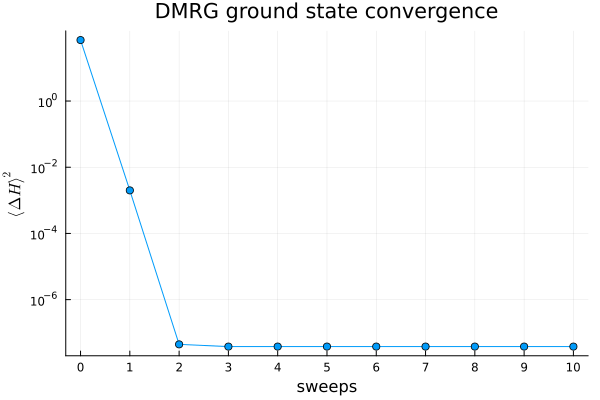

In [9]:
# Initial random MPS
χ0 = 25
ψ = randomMPS(s, χ0)
E = Float64[]
Var_E = Float64[]

# Push the initial energy before the sweeps
push!(E, inner(ψ', H, ψ))
Hψ = H * ψ   
push!(Var_E, inner(Hψ, Hψ) - E[end]^2)

@time for s in 1:10
    sweeps = Sweeps(1)
    maxdim!(sweeps, 100)   # set as you like
    cutoff!(sweeps, 1e-10)
    Eg, ψ = dmrg(H, ψ, sweeps)
    push!(E, Eg)
    
    # The variance of the energy is a good convergence check
    Hψ = H * ψ
    varE = inner(Hψ, Hψ) - Eg^2
    push!(Var_E, varE)
end

convergence = plot(0:10, 
    Var_E, 
    marker=:circle, 
    xlabel="sweeps", 
    ylabel=L"\langle \Delta H \rangle^2",
    xticks=0:10,
    title="DMRG ground state convergence", 
    yscale=:log10,
    yticks=[1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10],
    legend=false, 
)

display(convergence)


## 4. Example Model: Tilted Ising Chain (OBC)

> **A small history on the Ising model** 
>
> The classical Ising model is a toy model of spins that have nearest-neighbor coupling. Its Hamiltonian is usually written as
>$$
>H = -J \sum_{\langle i,j \rangle} s_i s_j \; - \; h \sum_i s_i,
>$$
>where $s_i = \pm 1$ are classical spin variables (up or down), $J$ is the coupling constant (positive $J$ favors alignment = ferromagnet, negative $J$ favors anti-alignment = antiferromagnet), the first sum runs over nearest-neighbor pairs $\langle i,j \rangle$, $h$ is an external magnetic field, and the second sum couples each spin to this field.
>It was first proposed by **Wilhelm Lenz (1920)** and studied by **Ernst Ising (1925)** to see if it is possible to have phase transitions in **1D** spin chains. He showed that there is **no** phase transition in 1D systems. Later, this model lept to fame when *Lars Onsager* (1944) showed it is possible to observe phase transitions for **2D** systems with a finite-$T$ transition, launching modern critical phenomena. 

Today, the **Ising model** threads through physics, computation, and inference. In the **quantum** chain, classical spins become Pauli operators, and we obtain much richer physics in these systems which makes it a loved model to study all over the physics community. For instance, the quantum Ising chain can undergo a **quantum phase transition**, where the system changes its state not by heating or cooling but purely by tuning a quantum parameter (like a magnetic field). It also exhibits **quantum entanglement**, where distant spins become correlated in ways with no classical counterpart. Even more intriguingly, these models can show **exotic excitations** that behave like particles emerging out of the collective behavior of the spins, providing playgrounds for ideas about quantum computation and new states of matter. 

**Classical vs Quantum Ising**

| Feature / Phenomenon | Classical Ising | Quantum Ising |
|----------------------|-----------------|---------------|
| Degrees of freedom   | Binary spins $s_i=\pm1$ | Pauli matrices $X_i, Z_i$ |
| Phase transitions    | 2D (Onsager) finite-$T$ transition | 1D chain has a **quantum critical point** at $h_x/J$ |
| Excitations          | Static domain walls | Quantum domain walls, kinks, avoided crossings |
| Integrability        | Many classical cases integrable | Transverse-field 1D model integrable, but tilt ($h_z$) breaks it |
| Entanglement         | Not defined (probabilistic correlations) | Rich entanglement spectrum, area-law ground states |
| Applications         | Magnetism, statistical mechanics | Quantum criticality, quench dynamics, MPS/DMRG benchmarks |


We will be focusing on the quantum **Transverse-field Ising model** in this notebook. 
A transverse field $h_x$ drives quantum fluctuations and a quantum phase transition; a longitudinal **tilt** $h_z$ breaks integrability, introduces domain walls and avoided crossings, and yields non-trivial ground states with modest entanglement—perfect for MPS/DMRG. We choose the Transverse-field Ising model because:
- It is simple to **specify** and **implement** as an MPO.  
- It displays **non-trivial ground states** amenable to MPS with modest bond dimension.  
- It lets us probe **order parameters**, **entanglement scaling**, and **correlation lengths** cleanly.  

$$
H \;=\; -J \sum_{i=1}^{N-1} Z_i Z_{i+1}
       \;-\; h_x \sum_{i=1}^{N} X_i
       \;-\; h_z \sum_{i=1}^{N} Z_i \, .
$$

Here “**tilted**” means simultaneous transverse ($h_x$) and longitudinal ($h_z$) fields. We use `Qubit` sites so that $X,Z$ have eigenvalues $\pm 1$ (no extra $1/2$ factors).

---

**Beyond Physics: Where the Ising Model Matters**

- **Collective phenomena outside physics**. Binary opinions with nearest-neighbor interaction map naturally to Ising couplings. This allows researchers to extend the Ising model to study human interactions in deciding their opinions, social influence, and contagion dynamics. [Lipowski, A., Lipowska, D., & Ferreira, A. L. Phase transition and power-law coarsening in Ising-doped voter model. Phys. Rev. E 73, 032103 (2006).](https://arxiv.org/abs/1706.03575)

- **Biophysics & networks.** On/off activity in gene regulation or neural models, and social influence or contagion dynamics, often admit effective Ising descriptions. [Schneidman et al., *Weak pairwise correlations imply strongly correlated network states in a neural population*, Nature 440, 1007 (2006)](https://www.nature.com/articles/nature04701).

- **Statistical genetics**. The Ising model has turned out to be a universal language for patterns and interactions. It has been used in genetics to detect hidden links between genes in complex diseases.[Majewski, J., Li, H., & Ott, J. The Ising model in physics and statistical genetics. Am. J. Hum. Genet. 69, 853–862 (2001).](https://pubmed.ncbi.nlm.nih.gov/11517425/)

- **Image denoising & segmentation (MRFs)**. These problems can be written as Ising-type energies, where smoothness terms are spin couplings and data terms are local fields; finding the best segmentation is equivalent to finding the Ising ground state. [Boykov, Veksler, Zabih, *Fast Approximate Energy Minimization via Graph Cuts*, IEEE Trans. Pattern Anal. Mach. Intell. 23, 1222 (2001)](https://www.cs.cornell.edu/rdz/Papers/BVZ-iccv99.pdf).

- **Information theory & quantum error correction.** Decoding thresholds of **topological codes** (e.g. toric/surface) map to random-bond Ising models on the Nishimori line, used to estimate maximum tolerable noise for scalable quantum error corrections. [Dennis, Kitaev, Landahl, Preskill, *Topological quantum memory*, J. Math. Phys. 43, 4452 (2002)](https://arxiv.org/abs/quant-ph/0110143).


We now put the MPO to work and run a two-site DMRG ground-state search. We record the energy after each sweep, then extract ground-state observables: site magnetizations $\langle X_i\rangle,\ \langle Z_i\rangle$, the entanglement-entropy profile, and the energy variance $\langle H^2\rangle-\langle H\rangle^2$ as a convergence sanity check.


After sweep 1 energy=-63.273574779735355  maxlinkdim=40 maxerr=2.94E-09 time=0.145
sweep  1 | E = -63.273574779735
         | Var(E) = 0.017459
After sweep 1 energy=-63.27772671201512  maxlinkdim=4 maxerr=9.79E-11 time=0.043
sweep  2 | E = -63.277726712015
         | Var(E) = 4.22829e-08
After sweep 1 energy=-63.27772671324217  maxlinkdim=4 maxerr=6.44E-11 time=0.026
sweep  3 | E = -63.277726713242
         | Var(E) = 3.81665e-08
After sweep 1 energy=-63.277726713242295  maxlinkdim=4 maxerr=6.05E-11 time=0.030
sweep  4 | E = -63.277726713242
         | Var(E) = 3.8161e-08
After sweep 1 energy=-63.27772671324206  maxlinkdim=4 maxerr=6.05E-11 time=0.025
sweep  5 | E = -63.277726713242
         | Var(E) = 3.81838e-08
After sweep 1 energy=-63.27772671324229  maxlinkdim=4 maxerr=6.05E-11 time=0.040
sweep  6 | E = -63.277726713242
         | Var(E) = 3.81574e-08
After sweep 1 energy=-63.27772671324247  maxlinkdim=4 maxerr=6.05E-11 time=0.040
sweep  7 | E = -63.277726713242
         | Var(E) 

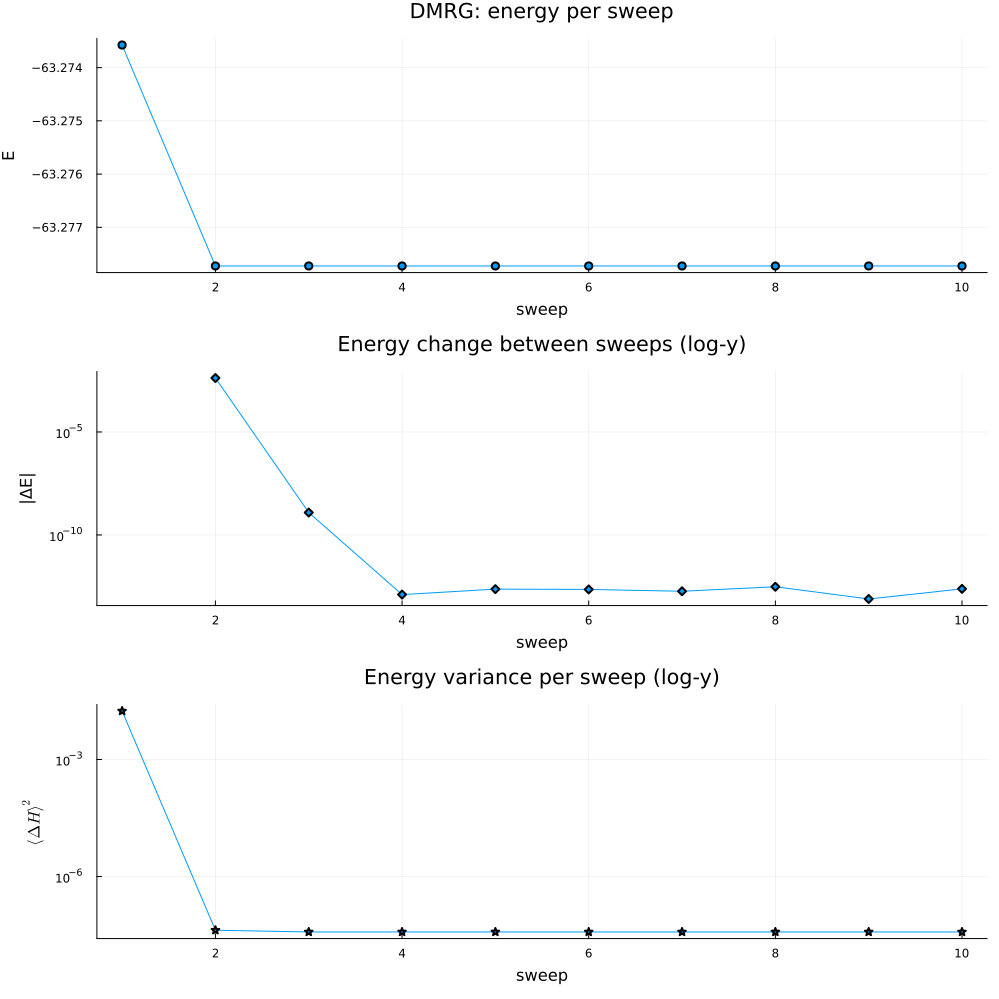

In [17]:
# <H^2> via apply(H, ψ): since H is Hermitian, <ψ|H^2|ψ> = ⟨Hψ|Hψ⟩
function energy_variance(ψ::MPS, H::MPO; Eg = nothing)
    ϕ = H * ψ;
    EH2 = inner(ϕ, ϕ)                               # ⟨ψ|H^2|ψ⟩
    Eg_val = isnothing(Eg) ? inner(ψ', H, ψ) : Eg
    return EH2 - Eg_val^2
end

# ----- Model parameters -----
N  = 50              # number of sites
J  = 1.0
hx = 0.6
hz = 0.2

# ----- Sites and MPO -----
s = siteinds("Qubit", N)

os = OpSum()
for i in 1:N-1
    os += -J,  "Z", i, "Z", i+1
end
for i in 1:N
    os += -hx, "X", i
    os += -hz, "Z", i
end
H = MPO(os, s)

# ----- DMRG: manual per-sweep loop so we can log energies without observers -----
function dmrg_convergence(H::MPO; χ0=10, S=10,
                          maxdim_sched = [40,80,160,240,400,600,800],
                          cutoff = 1e-10, noise_first = 1e-6)
    # s = siteinds(H)
    ψ = randomMPS(s, χ0)
    E = Float64[]
    Var_E = Float64[]

    for sw in 1:S
        sweeps = Sweeps(1)
        maxdim!(sweeps, maxdim_sched[min(sw, end)])
        cutoff!(sweeps, cutoff)
        noise!(sweeps, sw == 1 ? noise_first : 0.0)
        Eg, ψ = dmrg(H, ψ, sweeps);
        push!(E, Eg)
        @printf "sweep %2d | E = %.12f\n" sw Eg
        # The variance of the energy is a good convergence check
        varE = energy_variance(ψ, H; Eg=Eg)
        push!(Var_E, varE)
        @printf "         | Var(E) = %.6g\n" varE
    end
    return ψ, E, Var_E
end

ψg, E_s, Var_E = dmrg_convergence(H; χ0=10, S=10)

# Basic convergence plots (energy, |ΔE|, and ⟨ΔH⟩^2 on log scale)
ΔE = [NaN; abs.(diff(E_s))]
p1 = plot(
    1:length(E_s), 
    E_s, 
    marker=:circle, 
    xlabel="sweep", 
    ylabel="E",
    title="DMRG: energy per sweep", 
    legend=false
)
p2 = plot(
    1:length(ΔE), 
    ΔE, 
    marker=:diamond, 
    yaxis=:log10, 
    xlabel="sweep",
    ylabel="|ΔE|", 
    title="Energy change between sweeps (log-y)", 
    legend=false
)
p3 = plot(
    1:length(Var_E), 
    Var_E, 
    marker=:star, 
    yaxis=:log10, 
    xlabel="sweep",
    ylabel=L"\langle \Delta H \rangle^2", 
    title="Energy variance per sweep (log-y)", 
    legend=false
)
plot(p1, p2, p3, layout=(3,1), size=(1000,1000))



Ground-state energy E = -63.277726713242

Ground-state variance var(H) = 3.814e-08


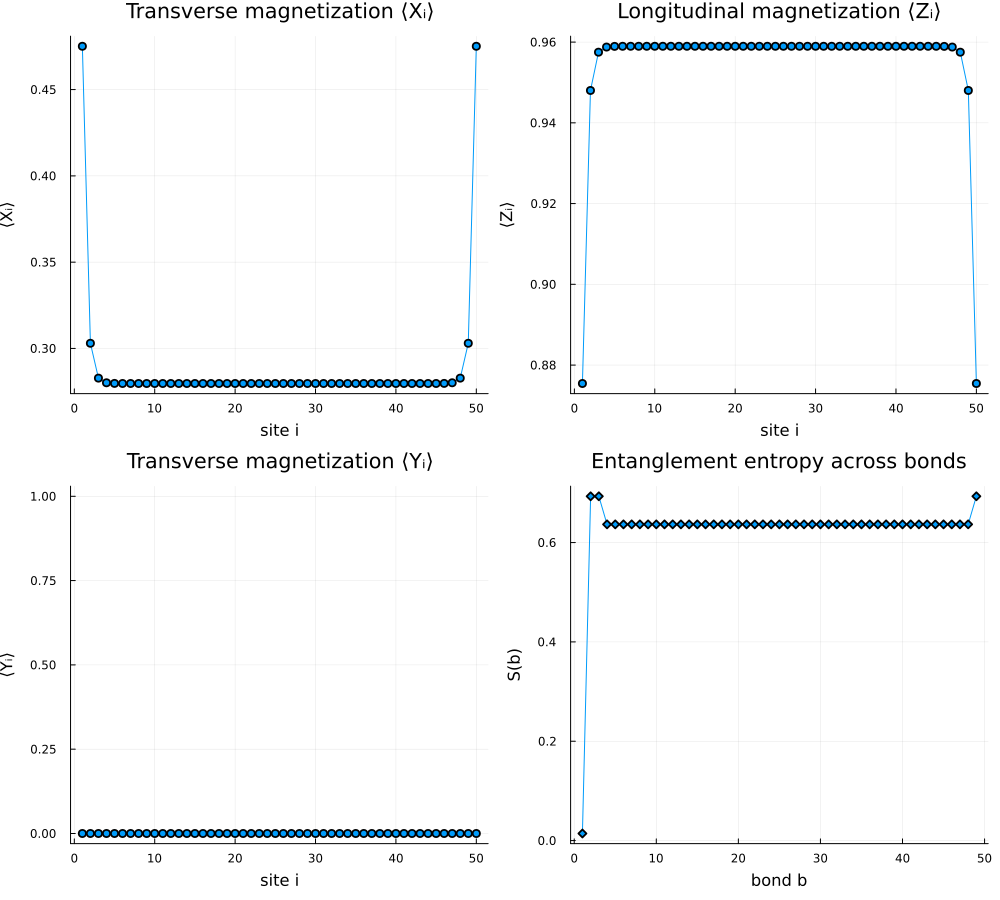

In [18]:
# ⟨O_i⟩ with O ∈ {"X","Y","Z"} (builds a tiny MPO once per site)
function on_site_expect(ψ::MPS, s, opstr::AbstractString)
    N = length(s)
    vals = zeros(Float64, N)
    for i in 1:N
        os = OpSum()
        os += 1.0, opstr, i
        Oi = MPO(os, s)
        vals[i] = real(inner(ψ', Oi, ψ))
    end
    return vals
end

# ----- Compute observables on the ground state ψg -----
mx = on_site_expect(ψg, s, "X")
my = on_site_expect(ψg, s, "Y")
mz = on_site_expect(ψg, s, "Z")

# Entanglement profile and energy variance
Sbond = [bond_entropy(ψg, b)[1] for b in 1:(N-1)]

Eg = E_s[end]
varH = energy_variance(ψg, H; Eg=Eg)
@printf "\nGround-state energy E = %.12f\n" Eg
@printf "\nGround-state variance var(H) = %.3e\n" varH

# ----- Plots -----
p_mx = plot(1:N, mx, marker=:circle, xlabel="site i", ylabel="⟨Xᵢ⟩",
            title="Transverse magnetization ⟨Xᵢ⟩", legend=false)
p_my = plot(1:N, my, marker=:circle, xlabel="site i", ylabel="⟨Yᵢ⟩",
            title="Transverse magnetization ⟨Yᵢ⟩", legend=false)
p_mz = plot(1:N, mz, marker=:circle, xlabel="site i", ylabel="⟨Zᵢ⟩",
            title="Longitudinal magnetization ⟨Zᵢ⟩", legend=false)
p_S  = plot(1:N-1, Sbond, marker=:diamond, xlabel="bond b", ylabel="S(b)",
            title="Entanglement entropy across bonds", legend=false)

plot(p_mx, 
p_mz, 
p_my, 
p_S, 
layout=(2,2), 
size=(1000,900), 
)
